# Ablation

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 17.07.2023

## 1. Setup

### 1.1 Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../../utils")

In [ ]:
import os
import warnings
from datetime import datetime

import mlflow
import numpy as np
import pandas as pd
import pickle
import plottable

from nichecompass.benchmarking import compute_benchmarking_metrics
from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

import scanpy as sc

from ablation_utils import *

### 1.2 Define Parameters

In [ ]:
latent_key = "nichecompass_latent"
spatial_key = "spatial"
latent_knng_key = "nichecompass_latent_knng"
spatial_knng_key = "spatial_knng"
gp_names_key = "nichecompass_gp_names"

### 1.4 Run Notebook Setup

In [ ]:
sc.set_figure_params(figsize=(6, 6))

In [ ]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [ ]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [ ]:
# Set mlflow tracking server (run it on the defined port)
mlflow.set_tracking_uri("http://localhost:8999")

### 1.5 Configure Paths and Directories

In [ ]:
artifact_folder_path = f"../../artifacts"
miscellaneous_folder_path = f"{artifact_folder_path}/miscellaneous"
figure_folder_path = f"{miscellaneous_folder_path}/ablation"

## 2. Ablation

### 2.1 Loss Weights, Gene Program Mask & Number of Neighbors

- Three single sample datasets are used (batch1 of Xenium Human Breast Cancer, batch1 of STARmap PLUS Mouse CNS, batch2 of Vizgen MERFISH Human Ovarian Cancer).
- Different combinations of the edge reconstruction loss, gene expression reconstruction loss, and KL divergence weighting hyperparameters are tested.
- Number of neighbors of the spatial neighborhood graph is varied between ```4```, ```8```, ```12```, and ```16```.
- GP mask is varied between fully connected gene program mask, unfiltered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=1.0), weakly filtered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=0.1), strongly filtered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=0.01).
- This results in a total of 208 (4x4x3x3) + (2x2x4x4) runs per dataset.

In [ ]:
ablation_task = "loss_weights"
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns", "vizgen_merfish_human_ovarian_cancer"]
cell_type_keys = ["cell_states", "Main_molecular_cell_type", "cell_type"]
batch_keys = [None, None, None]
experiment_ids = [3, 4, 5]

ablation_col = "loss_weights"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]
metric_cols = ["gcs", "nasw", "cnmi"]
metric_col_weights = [1, 1, 1]
metric_col_titles = ["Graph Connectivity Similarity",
                     "Niche Average Silhouette Width",
                     "Cell Type Normalized Mutual Info",
                     "Overall Score"]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [ ]:
# Load metrics and params of ablation runs from disk
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv", index_col=0)
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    
# Define params of interest
summary_df["loss_weights"] = summary_df.apply(lambda row: get_loss_weights(row), axis=1)
summary_df["gp_mask"] = summary_df.apply(lambda row: get_gp_mask(row), axis=1)
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

In [ ]:
# Validate that all runs are ok
# temp
summary_df[summary_df["dataset"] == "vizgen_merfish_human_ovarian_cancer"]["nichenet_keep_target_genes_ratio"].value_counts()

# temp
summary_df[(summary_df["dataset"] == "vizgen_merfish_human_ovarian_cancer") & (summary_df["nichenet_keep_target_genes_ratio"] == 0.01)]["n_neighbors"].value_counts()

In [ ]:
# Split into multiple files for each dataset for parallel metrics computation
for dataset in datasets:
    j = 0
    for i in np.arange(20, 240, 20):
        dataset_df = summary_df[summary_df["dataset"] == dataset]
        temp_df = dataset_df[j:i]
        temp_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv")
        j = i

Now run respective jobs in ```../notebooks/slurm_job_submission.ipynb```.

In [ ]:
# tmp
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns"]

In [ ]:
# Load files with computed metrics and join to metadata
summary_df = pd.DataFrame()
for dataset in datasets:
    for i in np.arange(40, 180, 20):
        metadata_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv")
        if dataset == "starmap_plus_mouse_cns":
            metrics_df = pd.read_csv(f"{ablation_folder_path}/tmp/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv_metrics_temp.csv")
        else:
            metrics_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv_metrics_temp.csv")
        iteration_df = metadata_df.merge(metrics_df,on=["dataset", "timestamp"], how="left")
        iteration_df.drop("Unnamed: 0_x", axis=1, inplace=True)
        iteration_df.drop("Unnamed: 0_y", axis=1, inplace=True)
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)

In [ ]:
# Compute overall score
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)
order = summary_df.groupby("loss_weights").mean("overall_score").sort_values("overall_score", ascending=False).index

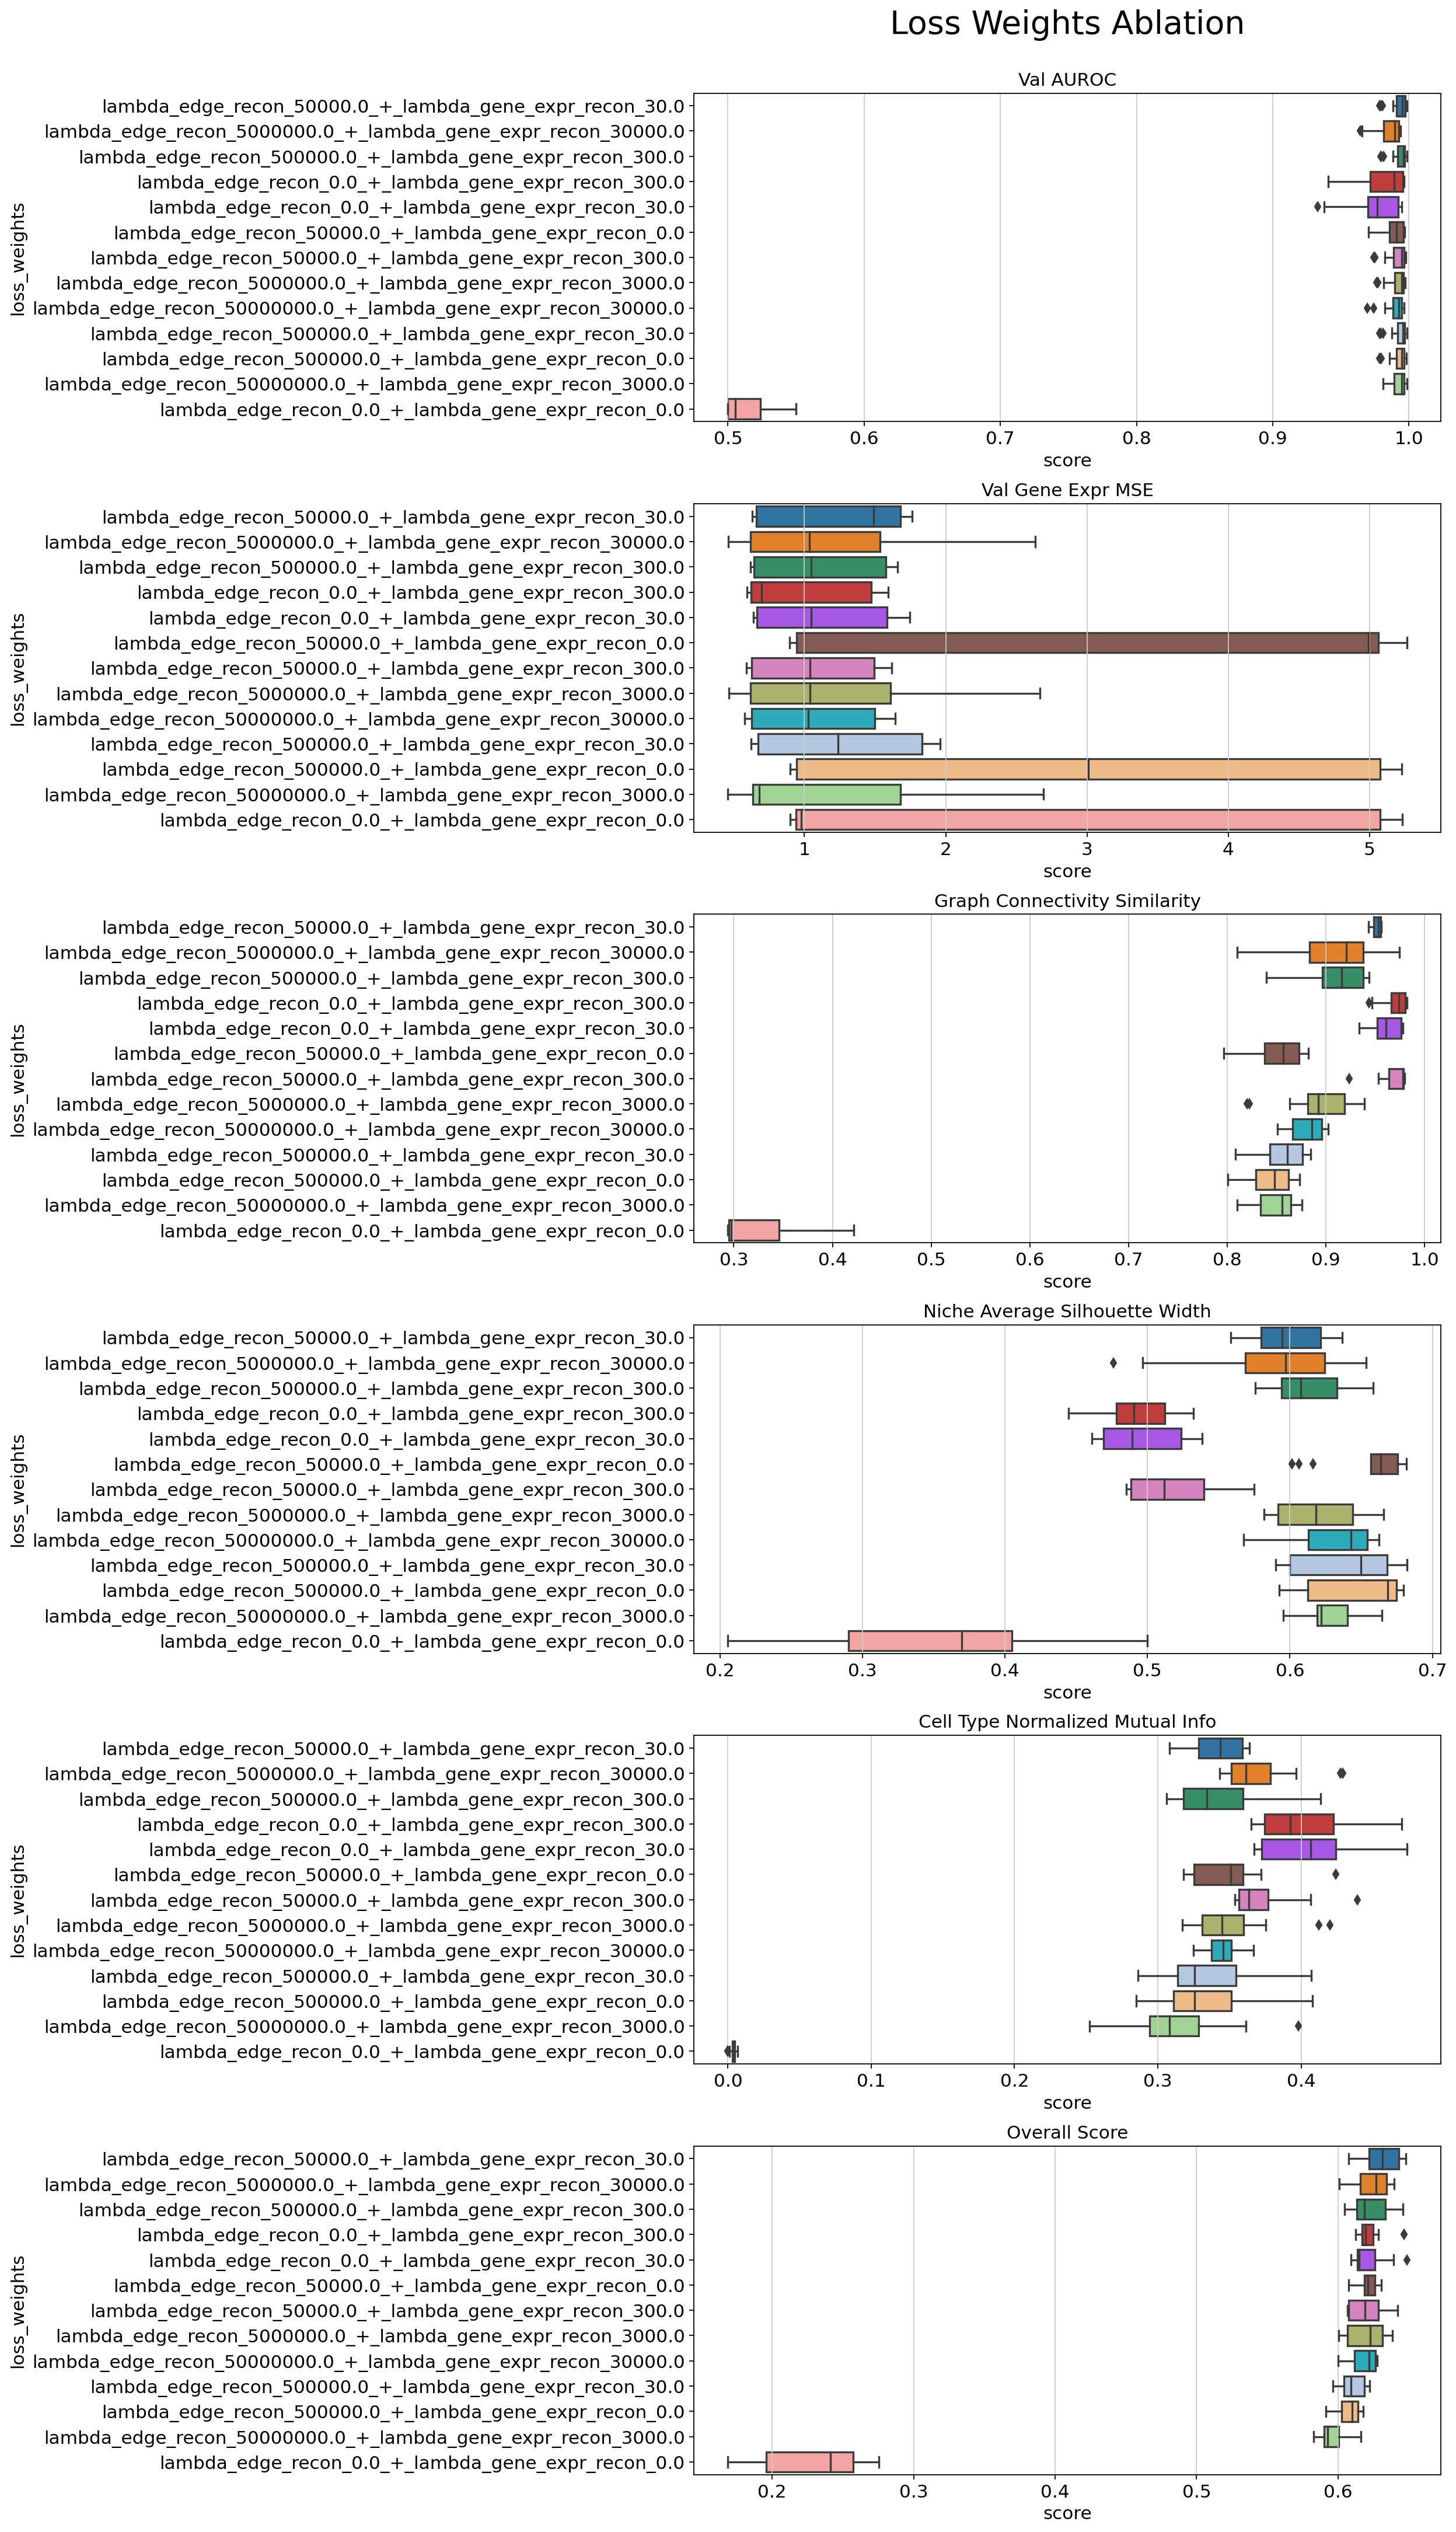

In [98]:
# Generate loss weights boxplots
plot_metrics_boxplot(
    fig_title="Loss Weights Ablation",
    df=summary_df,
    group_col="loss_weights",
    metric_cols=["val_auroc_score", "val_gene_expr_mse_score"] + metric_cols + ["overall_score"],
    metric_col_titles=["Val AUROC", "Val Gene Expr MSE"] + metric_col_titles,
    order=order,
    save_fig=True,
    figure_folder_path=figure_folder_path,
    file_name="loss_weights_ablation_metrics.png")

In [ ]:
# Prepare metrics table plot
aggregate_df = summary_df.groupby(["dataset", "loss_weights"]).mean("overall_score").sort_values("overall_score", ascending=False)[metric_cols].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols,
   var_name="score_type", 
   value_name="score")

# Bring df in right order for table
unrolled_df = unrolled_df.sort_values("dataset")

In [115]:
summary_df.groupby(["dataset", "loss_weights"]).mean()["cnmi"]

dataset                     loss_weights                                                 
starmap_plus_mouse_cns      lambda_edge_recon_0.0_+_lambda_gene_expr_recon_0.0               0.005008
                            lambda_edge_recon_0.0_+_lambda_gene_expr_recon_30.0              0.375646
                            lambda_edge_recon_0.0_+_lambda_gene_expr_recon_300.0             0.378869
                            lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_0.0           0.341979
                            lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_30.0          0.342055
                            lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_300.0         0.361597
                            lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_0.0          0.323674
                            lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_30.0         0.321828
                            lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_300.0        0

In [111]:
summary_df.groupby(["loss_weights"]).mean()["gcs"]

loss_weights
lambda_edge_recon_0.0_+_lambda_gene_expr_recon_0.0               0.325416
lambda_edge_recon_0.0_+_lambda_gene_expr_recon_30.0              0.961629
lambda_edge_recon_0.0_+_lambda_gene_expr_recon_300.0             0.971536
lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_0.0           0.853784
lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_30.0          0.951398
lambda_edge_recon_50000.0_+_lambda_gene_expr_recon_300.0         0.968977
lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_0.0          0.842936
lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_30.0         0.856893
lambda_edge_recon_500000.0_+_lambda_gene_expr_recon_300.0        0.912439
lambda_edge_recon_5000000.0_+_lambda_gene_expr_recon_3000.0      0.892853
lambda_edge_recon_5000000.0_+_lambda_gene_expr_recon_30000.0     0.911329
lambda_edge_recon_50000000.0_+_lambda_gene_expr_recon_3000.0     0.847763
lambda_edge_recon_50000000.0_+_lambda_gene_expr_recon_30000.0    0.880922
Name: gcs, dtype: float64

In [88]:
metric_col_weights = [1, 1, 1]

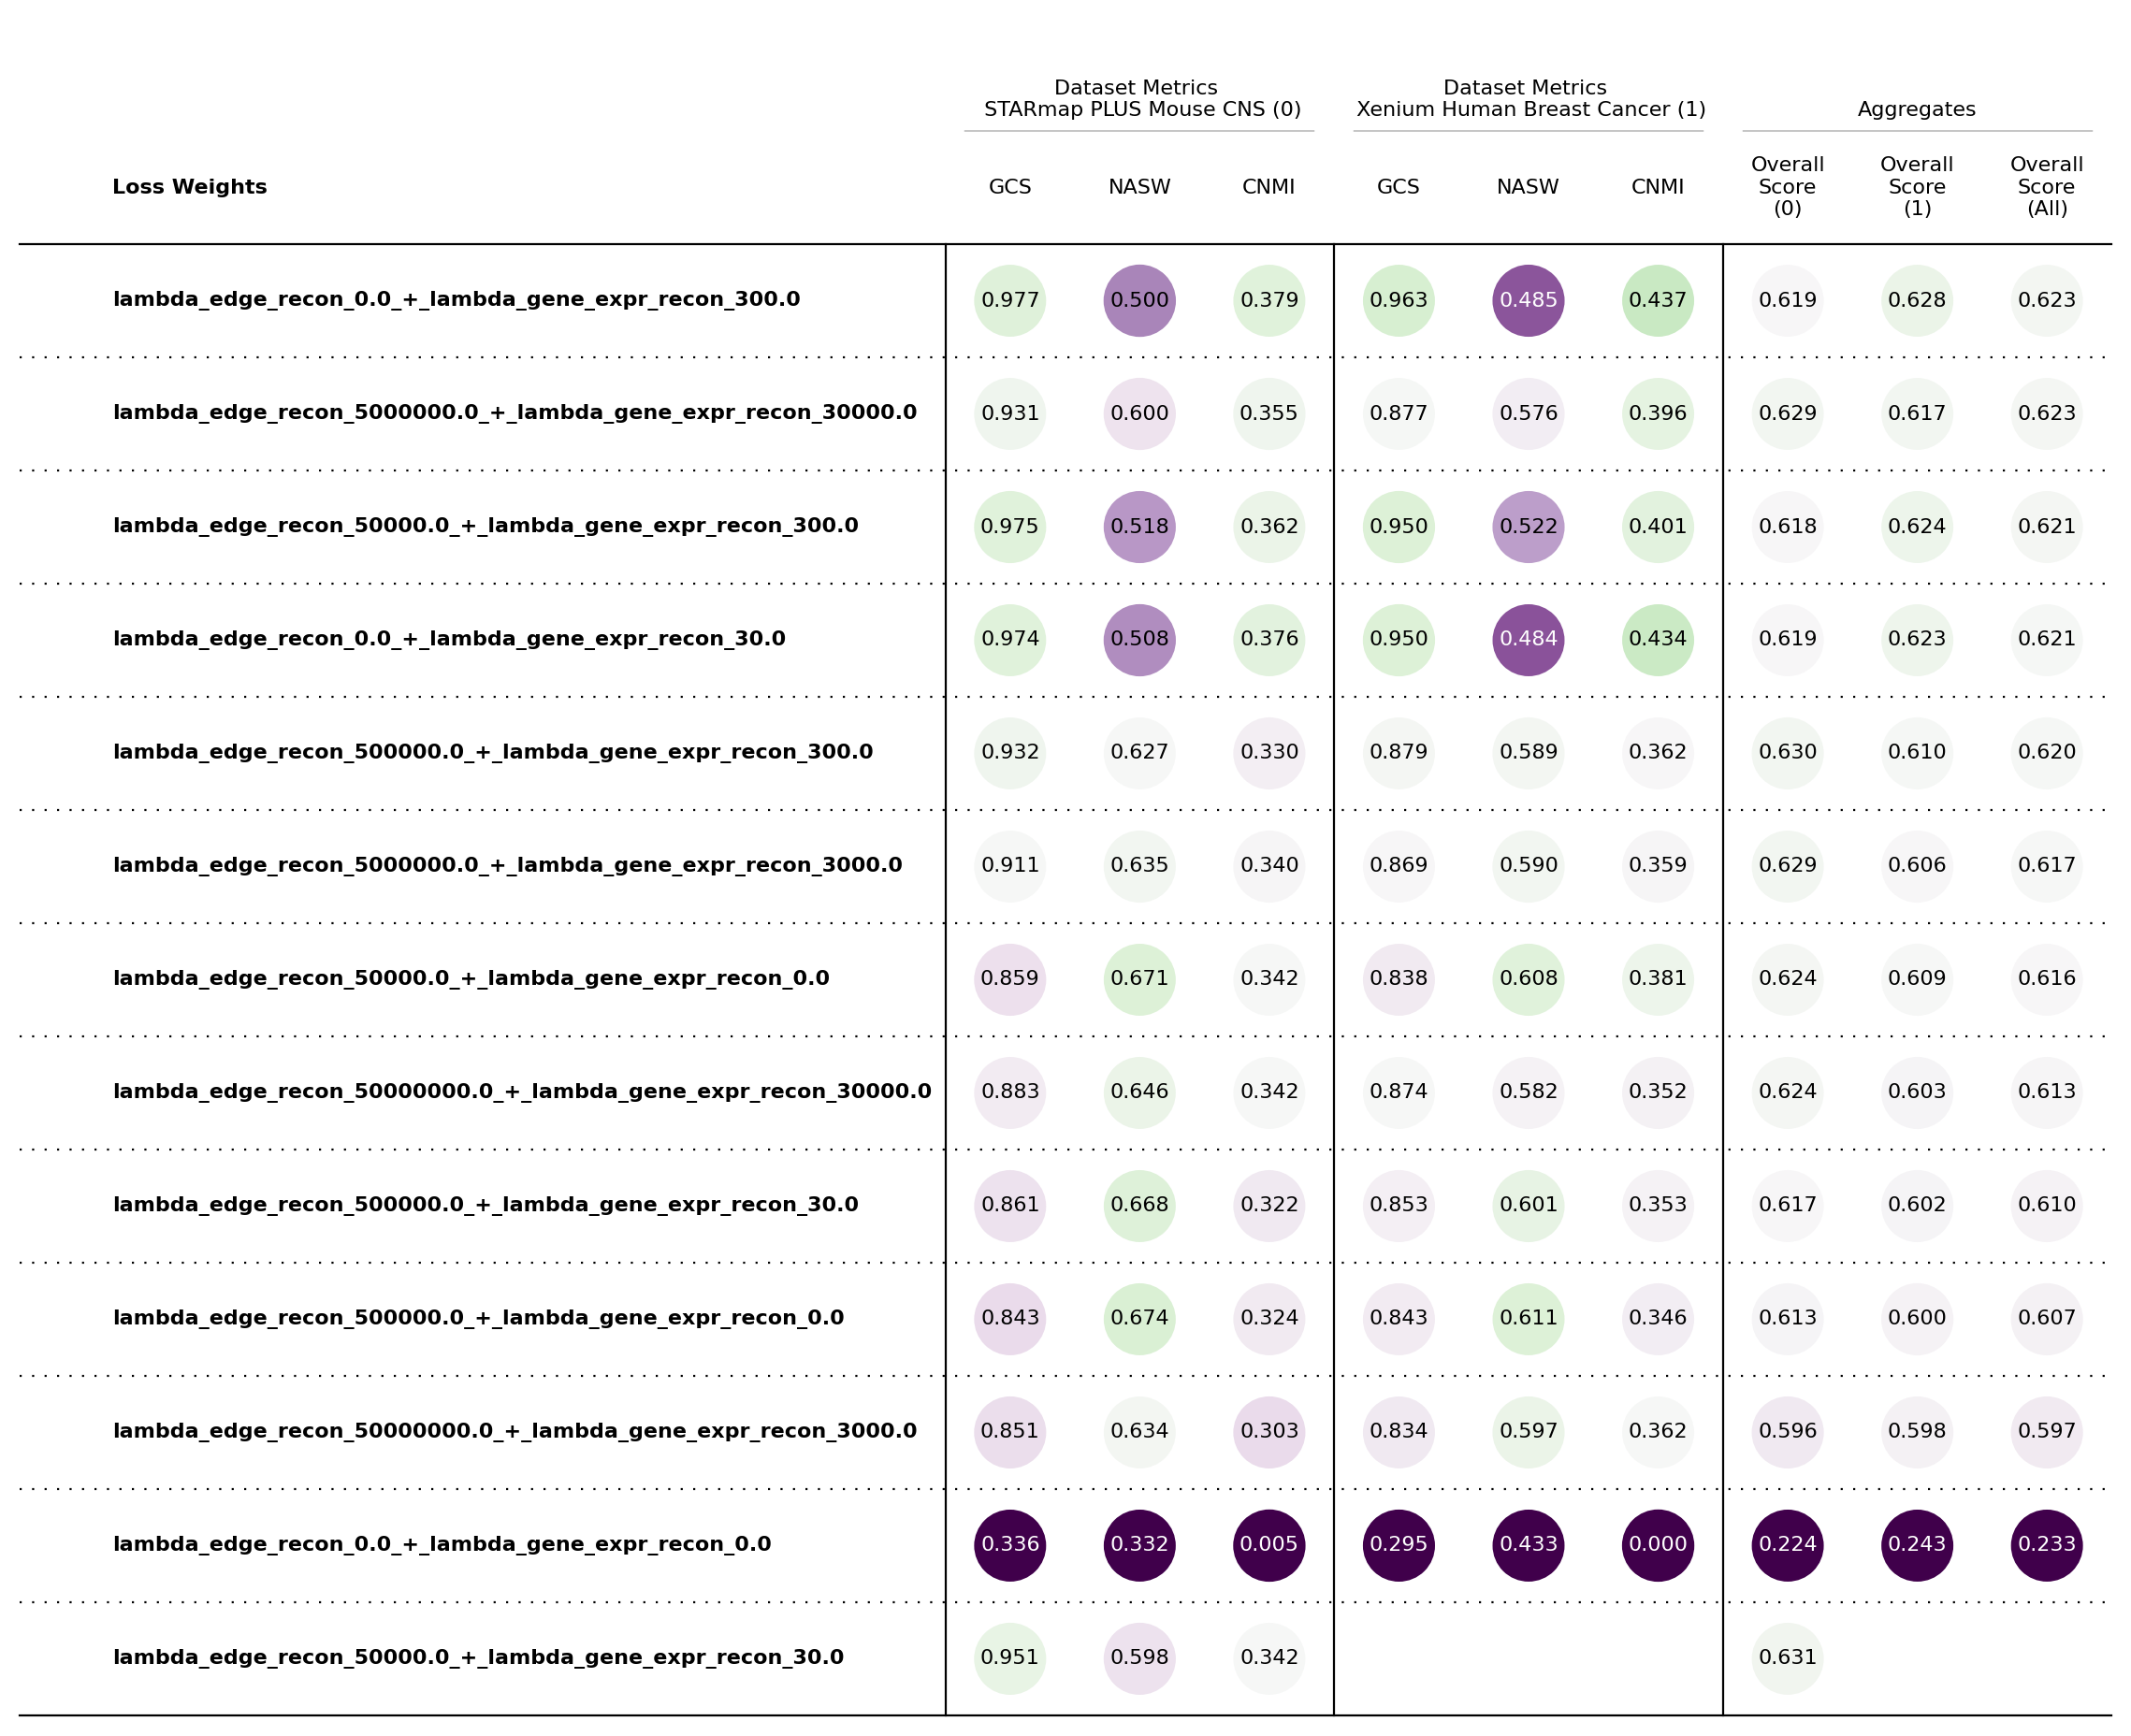

In [110]:
plot_metrics_table(
    df=unrolled_df,
    ablation_col=ablation_col,
    ablation_col_width=5,
    group_col=dataset_col,
    metric_cols=metric_cols,
    metric_col_weights=metric_col_weights,
    metric_col_width=0.7,
    plot_width=18,
    plot_height=15,
    show=True,
    save_dir=None,
    save_name="ablation_results.svg")

In [ ]:
summary_df.sort_values("nasw", ascending=False).head(60)

In [ ]:
artifact_folder_path

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            dataset="xenium_human_breast_cancer",
                            task="loss_weights_ablation",
                            timestamps=["01072023_101716_27"],
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=50.,
                            save_fig=False)

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            dataset="xenium_human_breast_cancer",
                            task="loss_weights_ablation",
                            timestamps=["30062023_143855_10"],
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=50.,
                            save_fig=False)

In [ ]:
# Remove runs with 0 lambda for both losses
summary_df = summary_df[summary_df["loss_weights"] != "lambda_edge_recon_0.0_+_lambda_gene_expr_recon_0.0"]

In [ ]:
# GP mask plot
plot_metrics(fig_title="Gene Program Mask Ablation",
             df=summary_df,
             group_col="gp_mask",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score", "gcs", "nasw", "cnmi", "metrics_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="gp_mask_ablation_metrics.png")

In [ ]:
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

In [ ]:
# Number of neighbors plot
plot_metrics(fig_title="Number of Neighbors Ablation",
             df=summary_df,
             group_col="n_neighbors",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score", "gcs", "nasw", "cnmi", "metrics_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="n_neighbors_ablation_metrics.png")

In [ ]:
# GP mask plot
plot_metrics(fig_title="Gene Program Mask Ablation",
             df=summary_df,
             group_col="n_neighbors",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=False,
             figure_folder_path=figure_folder_path,
             file_name="gp_mask_ablation_metrics.png")

In [ ]:
ablation_col = "loss_weights"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]
metric_cols = ["cas", "mlami", "gcs", "cca"]
metric_cols_weights = [0.6, 0.6, 0.6, 0.4]
metric_score_cols = [metric_col + "_points" for metric_col in metric_cols]

# Compute ablation points
points_df = compute_ablation_points(
    df=test_df,
    group_col=ablation_col,
    metric_cols=metric_cols,
    metric_cols_weights=metric_cols_weights,
    sort_metric_col="total_score")

In [ ]:
# Plot metrics
for dataset in datasets:
    dataset_df = points_df[points_df["dataset"] == dataset]
    plot_metrics(
        fig_title=f"Loss Weights Ablation: {dataset}",
        df=dataset_df,
        group_col="loss_weights",
        metric_cols=metric_cols,
        plot_ratio_active_gps=False,
        save_fig=False,
        file_name="ablation_metrics.png")

In [ ]:
ablation_col = "loss_weights"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]
metric_cols = ["cas", "mlami", "gcs", "cca"]
metric_cols_weights = [0.6, 0.6, 0.6, 0.4]
metric_score_cols = [metric_col + "_points" for metric_col in metric_cols]

In [ ]:
# Unroll points df and compute means over group columns and score type
unrolled_points_df = pd.melt(points_df, 
   id_vars=group_cols,
   value_vars=metric_score_cols,
   var_name="score_type", 
   value_name="score")

# Compute metric means over all runs
mean_points_df = unrolled_points_df.groupby(group_cols + ["score_type"]).mean()
mean_points_df.reset_index(inplace=True)

In [ ]:
mean_points_df

In [ ]:
plot_ablation_points(df=mean_points_df,
                     ablation_col=ablation_col,
                     ablation_col_width=7,
                     group_col=dataset_col,
                     metric_cols=metric_score_cols,
                     show=True,
                     save_dir=None,
                     save_name="ablation_results.svg")

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            task=ablation_task + "_ablation",
                            timestamps=timestamps,
                            dataset="xenium_human_breast_cancer",
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=30.,
                            save_fig=False)

### 2.2 Neighbor Sampling

In [ ]:
ablation_task = "neighbor_sampling"
cross_ablation_task = "loss_weights"
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns", "vizgen_merfish_human_ovarian_cancer"]
cell_type_keys = ["cell_states", "Main_molecular_cell_type", "cell_type"]
batch_keys = [None, None, None]
experiment_ids = [9, 10, 11]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [ ]:
# Retrieve metrics and params of ablation runs from mlflow and save to disk
summary_df = pd.DataFrame()
for dataset, experiment_id in zip(datasets, experiment_ids):
    runs_info = mlflow.list_run_infos(experiment_id)
    for run_info in runs_info:
        run = mlflow.get_run(run_info.run_uuid)
        if run.info.status == "RUNNING":
            continue
        run_dict = {"dataset": dataset}
        run_dict["timestamp"] = run.data.params["timestamp"]
        run_dict["val_auroc_score"] = run.data.metrics.get("val_auroc_score", np.nan)
        run_dict["val_gene_expr_mse_score"] = run.data.metrics.get("val_gene_expr_mse_score", np.nan)
        run_dict["n_neighbors"] = run.data.params["n_neighbors"]
        run_dict["n_sampled_neighbors"] = run.data.params["n_sampled_neighbors_"]
        run_df = pd.DataFrame(run_dict, index=[0])
        summary_df = pd.concat([summary_df, run_df], ignore_index=True)

for dataset in datasets:
    summary_df[summary_df["dataset"] == dataset].to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv", index=False)

In [ ]:
# Load metrics and params of ablation runs from disk
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv")
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)

summary2_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path.replace(ablation_task, cross_ablation_task)}/mlflow_summary_{cross_ablation_task}_ablation_{dataset}.csv", index_col=0)
    summary2_df = pd.concat([summary2_df, dataset_df], ignore_index=True)

In [ ]:
# Only keep relevant runs and params from previous ablation
summary2_df = summary2_df[(summary2_df["lambda_edge_recon_"] == 500000.0) &
           (summary2_df["lambda_gene_expr_recon_"] == 300.0) &
           (summary2_df["nichenet_keep_target_genes_ratio"] == 0.01)][
    ["dataset", "timestamp", "val_auroc_score", "val_gene_expr_mse_score", "n_neighbors"]]

summary2_df["n_sampled_neighbors"] = -1 # No neighbor sampling

In [ ]:
summary_df_filtered = summary_df[(summary_df["n_neighbors"].isin([4, 8, 12, 16])) & (summary_df["n_sampled_neighbors"] == 4)]
summary_df = pd.concat([summary_df_filtered, summary2_df], ignore_index=True)
summary_df["n_sampled_neighbors"] = summary_df["n_sampled_neighbors"].astype(str)

In [ ]:
summary_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_processed.csv", index=False)

In [ ]:
summary_df

In [ ]:
# Neighbor sampling comparison vs without plot
plot_metrics(fig_title="Neighbor Sampling Ablation",
             df=summary_df,
             group_col="n_sampled_neighbors",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="neighbor_sampling_ablation_metrics.png")

### 2.3 Encoder Architecture

In [ ]:
ablation_task = "encoder_architecture"
cross_ablation_task = "loss_weights"
datasets = ["xenium_human_breast_cancer"]
cell_type_keys = ["cell_states"]
batch_keys = [None]
experiment_ids = [7]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [ ]:
# Retrieve metrics and params of ablation runs from mlflow and save to disk
summary_df = pd.DataFrame()
for dataset, experiment_id in zip(datasets, experiment_ids):
    runs_info = mlflow.list_run_infos(experiment_id)
    for run_info in runs_info:
        run = mlflow.get_run(run_info.run_uuid)
        if run.info.status == "RUNNING":
            continue
        run_dict = {"dataset": dataset}
        run_dict["timestamp"] = run.data.params["timestamp"]
        run_dict["val_auroc_score"] = run.data.metrics.get("val_auroc_score", np.nan)
        run_dict["val_gene_expr_mse_score"] = run.data.metrics.get("val_gene_expr_mse_score", np.nan)
        run_dict["n_neighbors"] = run.data.params["n_neighbors"]
        run_dict["n_layers_encoder"] = run.data.params["n_layers_encoder_"]
        run_dict["conv_layer_encoder"] = run.data.params["conv_layer_encoder_"]
        run_df = pd.DataFrame(run_dict, index=[0])
        summary_df = pd.concat([summary_df, run_df], ignore_index=True)

for dataset in datasets:
    summary_df[summary_df["dataset"] == dataset].to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv")

In [ ]:
summary_df = summary_df[summary_df["n_neighbors"].isin(["4", "8"])]

In [ ]:
# GATv2 vs GCN plot
plot_metrics(fig_title="Encoder Layer Type Ablation",
             df=summary_df,
             group_col="conv_layer_encoder",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="encoder_layer_type_ablation_metrics.png")

#### 2.1.2 Categorical Covariates Contrastive Loss

### 2.5 Spatial Neighborhood Graph

In [ ]:
visualize_niches(artifact_folder_path=artifact_folder_path,
                 dataset=dataset,
                 task=ablation_task + "_ablation",
                 timestamps=timestamps,
                 sample_key="batch",
                 latent_key=latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30.)

### 2.5 Gene Program Mask

In [ ]:
"""
# Log additional mlflow param
run_ids = []
runs_info = mlflow.list_run_infos(3)
for run_info in runs_info:
    run = mlflow.get_run(run_info.run_uuid)
    if "add_fc_gps_instead_of_gp_dict_gps" not in run.data.params:
        run_ids.append(run_info.run_uuid)
        
for run_id in run_ids:
    with mlflow.start_run(run_id=run_id) as run:
        mlflow.log_param("add_fc_gps_instead_of_gp_dict_gps", True)
"""